In [17]:
import pickle
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from layers import conv_layer, max_pool_2x2, full_layer
import datetime

In [2]:
DATA_PATH = "/home/younseun/columbus_study/04_learning_tensorflow/~envs/tensorflow/python_code/Oreilly-Learning-TensorFlow-master/04__convolutional_neural_networks/cifar-10-batches-py"
DATA_PATH = "cifar-10-batches-py"
BATCH_SIZE = 50
STEPS = 500000
STEPS = 1000

In [5]:
def one_hot(vec, vals=10):
    n = len(vec)
    out = np.zeros((n, vals))
    out[range(n), vec] = 1
    return out

In [6]:
def unpickle(file):
    with open(os.path.join(DATA_PATH, file), 'rb') as fo:
        u = pickle._Unpickler(fo)
        u.encoding = 'latin1'
        dict = u.load()
    return dict

In [7]:
def display_cifar(images, size):
    n = len(images)
    plt.figure()
    plt.gca().set_axis_off()
    im = np.vstack([np.hstack([images[np.random.choice(n)] for i in range(size)])
                    for i in range(size)])
    plt.imshow(im)
    plt.show()

In [8]:
class CifarLoader(object):
    """
    Load and mange the CIFAR dataset.
    (for any practical use there is no reason not to use the built-in dataset handler instead)
    """
    def __init__(self, source_files):
        self._source = source_files
        self._i = 0
        self.images = None
        self.labels = None

    def load(self):
        data = [unpickle(f) for f in self._source]
        images = np.vstack([d["data"] for d in data])
        n = len(images)
        self.images = images.reshape(n, 3, 32, 32).transpose(0, 2, 3, 1)\
            .astype(float) / 255
        self.labels = one_hot(np.hstack([d["labels"] for d in data]), 10)
        return self

    def next_batch(self, batch_size):
        x, y = self.images[self._i:self._i+batch_size], \
               self.labels[self._i:self._i+batch_size]
        self._i = (self._i + batch_size) % len(self.images)
        return x, y

    def random_batch(self, batch_size):
        n = len(self.images)
        ix = np.random.choice(n, batch_size)
        return self.images[ix], self.labels[ix]

In [9]:
class CifarDataManager(object):
    def __init__(self):
        self.train = CifarLoader(["data_batch_{}".format(i) for i in range(1, 6)])\
            .load()
        self.test = CifarLoader(["test_batch"]).load()

In [10]:
def create_cifar_image():
    d = CifarDataManager()
    print("Number of train images: {}".format(len(d.train.images)))
    print("Number of train labels: {}".format(len(d.train.labels)))
    print("Number of test images: {}".format(len(d.test.images)))
    print("Number of test labels: {}".format(len(d.test.labels)))
    images = d.train.images
    display_cifar(images, 10)

In [69]:
cifar = CifarDataManager()
total_images = cifar.train.images
total_labels = cifar.train.labels
batch = cifar.train.next_batch(BATCH_SIZE)

In [54]:
type(batch), len(batch)
batch[0]  # 50개 데이터에 대한 32 * 32 의 3개채널 데이터
batch[1]  # 결과에 대한 one-hot 코드

print('batch[0] Dimension : {}'.format(batch[0].shape))   # (50, 32, 32, 3)
print('batch[1] Dimension : {}'.format(batch[1].shape))   # (50,10)

batch[0] Dimension : (50, 32, 32, 3)
batch[1] Dimension : (50, 10)


In [ ]:
print('total image dimension : {},   total label dimension : {}'.format(total_images.shape, total_labels.shape))
total_images[0], total_labels[0]

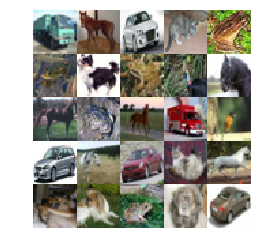

In [65]:
display_cifar(total_images, 5)

In [12]:
cifar = CifarDataManager()

x = tf.placeholder(tf.float32, shape=[None, 32, 32, 3])
y = tf.placeholder(tf.float32, shape=[None, 10])
keep_prob = tf.placeholder(tf.float32)

x_placeholder = x
conv1 = conv_layer(x, shape=[5,5,3,32])
conv1_pool = max_pool_2x2(conv1)
conv2 = conv_layer(conv1_pool, shape=[5,5,32,64])
conv2_pool = max_pool_2x2(conv2)

conv2_plat = tf.reshape(conv2_pool, [-1, 8*8*64])
full_1 = tf.nn.relu(full_layer(conv2_plat, 1024))
full_drop = tf.nn.dropout(full_1, keep_prob)

y_conv = full_layer(full_drop, 10)

# Loss Function
cross_entropy = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=y, logits=y_conv))
train_step = tf.train.AdamOptimizer(1e-3).minimize(cross_entropy)

correct_predict = tf.equal(tf.argmax(y_conv, 1), tf.argmax(y,1))
accuracy =  tf.reduce_mean(tf.cast(correct_predict, tf.float32))

In [161]:
# 결과 Data, Dimension 확인용
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    batch = cifar.train.next_batch(BATCH_SIZE)
    outs = sess.run([x_placeholder,conv1,conv1_pool,conv2,conv2_pool,conv2_plat,full_1,full_drop,y_conv, cross_entropy, train_step], 
                    feed_dict={x:batch[0],y:batch[1], keep_prob: 0.5})

In [162]:
print('outs Dimension : {}'.format(len(outs)))
print('{}         << x_placeholder'.format(outs[0].shape))
print('{}        << conv1'.format(outs[1].shape))
print('{}        << conv1_pool'.format(outs[2].shape))
print('{}        << conv2'.format(outs[3].shape))
print('{}          << conv2_pool'.format(outs[4].shape))
print('{}              << conv2_plat'.format(outs[5].shape))
print('{}              << full_1'.format(outs[6].shape))
print('{}              << full_drop'.format(outs[7].shape))
print('{}                << y_conv'.format(outs[8].shape))

outs[9] # << Cross Entropy

outs Dimension : 11
(50, 32, 32, 3)         << x_placeholder
(50, 32, 32, 32)        << conv1
(50, 16, 16, 32)        << conv1_pool
(50, 16, 16, 64)        << conv2
(50, 8, 8, 64)          << conv2_pool
(50, 4096)              << conv2_plat
(50, 1024)              << full_1
(50, 1024)              << full_drop
(50, 10)                << y_conv


20.838442

In [19]:
STEPS = 1000
X = cifar.test.images.reshape(10, 1000, 32, 32, 3)
Y = cifar.test.labels.reshape(10, 1000, 10)

def test(sess):
    X = cifar.test.images.reshape(10, 1000, 32, 32, 3)
    Y = cifar.test.labels.reshape(10, 1000, 10)
    acc = np.mean([sess.run(accuracy, feed_dict={x: X[i], y_: Y[i], keep_prob: 1.0})
                   for i in range(10)])
    print("Accuracy: {:.4}%".format(acc * 100))

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    for i in range(STEPS):
        batch = cifar.train.next_batch(BATCH_SIZE)
        outs = sess.run(train_step, feed_dict={x:batch[0],y:batch[1], keep_prob: 0.5})
        if (i+1) % 100 == 0:   # 평가 실시
            step_outs_accuracy = np.mean([sess.run([accuracy], feed_dict={x: X[j], y: Y[j], keep_prob: 1.0}) for j in range(10)])
            print('{} : Accuraty : {}            {} '.format(i+1, step_outs_accuracy, datetime.datetime.now()))
    print('Completed')

0 : Accuraty : 0.0957999974489212            2018-08-26 15:34:42.088002 
100 : Accuraty : 0.3725999891757965            2018-08-26 15:36:03.484556 
200 : Accuraty : 0.4319000244140625            2018-08-26 15:37:31.204954 
300 : Accuraty : 0.4582999646663666            2018-08-26 15:38:57.690702 
400 : Accuraty : 0.4803999960422516            2018-08-26 15:40:25.659601 
500 : Accuraty : 0.5036999583244324            2018-08-26 15:41:58.027108 
600 : Accuraty : 0.5042000412940979            2018-08-26 15:43:24.217122 
700 : Accuraty : 0.5439000129699707            2018-08-26 15:44:53.493149 
800 : Accuraty : 0.5512999892234802            2018-08-26 15:46:21.703899 
900 : Accuraty : 0.5440000295639038            2018-08-26 15:47:32.969883 
Completed
